# Enron Data Person of Interest Project

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.


In this project;

* The data were analyzed,
* NaN values in financial attributes were changed to zeros,
* Nan values in mailing features were changed to median value of related feature,
* Outliers were detected and removed from dataset,
* Features were selected based on the result of analysis in SelectKBest for classification (f_classif),
* New features were added to improve performance,
* NaiveBayes, RandomForest and AdaBoost classifiers were tried with different parameters and best classification method was chosen.


In [107]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [108]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
df = pd.DataFrame.from_dict(data_dict, orient='index')
df.head()


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


There NaN values in some features of the dataset, for simplification of the analysis, these NaN strings shall be replaced with null values. 

In [109]:
df = df.replace('NaN', np.nan)

### Dataset Analysis & Wrangling

In [110]:
print "# of investigated people: ", df['poi'].count()
print "Person of interest distirbution: ", df.groupby('poi')['poi'].count()
print "Initial feature set: ", df.shape[1]

# of investigated people:  146
Person of interest distirbution:  poi
False    128
True      18
Name: poi, dtype: int64
Initial feature set:  21


There are 146 people, 18 of which is labeled as person of interes in the dataset. There are total of 21 features which are categorized into 2 groups, financial and mailing features.

In [111]:
print 'NaN values of features'
df.isnull().sum()

NaN values of features


salary                        51
to_messages                   60
deferral_payments            107
total_payments                21
exercised_stock_options       44
bonus                         64
restricted_stock              36
shared_receipt_with_poi       60
restricted_stock_deferred    128
total_stock_value             20
expenses                      51
loan_advances                142
from_messages                 60
other                         53
from_this_person_to_poi       60
poi                            0
director_fees                129
deferred_income               97
long_term_incentive           80
email_address                 35
from_poi_to_this_person       60
dtype: int64

Missing financial features can be filled with zeros since they are related with amount of money. 

In [112]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
df[financial_features] = df[financial_features].fillna(0)

Missing values in mailing features are very interesting since the possibility of those people to have received or sent any email is very low. If those values were filled with zeros, in classification phase those values may effect the success of the method. Therefore, filling with average values seems more logical. 

In [113]:
email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
df[email_features] = df[email_features].fillna(df[email_features].median())
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,0.0,2195.0,152.0,65.0,False,0.0,-3081055.0,304805.0,phillip.allen@enron.com,47.0
BADUM JAMES P,0.0,1211.0,178980.0,182466.0,257817.0,0.0,0.0,740.5,0.0,257817.0,...,0.0,41.0,0.0,8.0,False,0.0,0.0,0.0,NaN,35.0
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,...,0.0,29.0,864523.0,0.0,False,0.0,-5104.0,0.0,james.bannantine@enron.com,39.0
BAXTER JOHN C,267102.0,1211.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,740.5,0.0,10623258.0,...,0.0,41.0,2660303.0,8.0,False,0.0,-1386055.0,1586055.0,NaN,35.0
BAY FRANKLIN R,239671.0,1211.0,260455.0,827696.0,0.0,400000.0,145796.0,740.5,-82782.0,63014.0,...,0.0,41.0,69.0,8.0,False,0.0,-201641.0,0.0,frank.bay@enron.com,35.0


### Outlier Analysis

In [114]:
df.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
count,1.460000e+02,146.000000,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,1.460000e+02,146.000000,1.460000e+02,1.460000e+02,1.460000e+02,146.000000
mean,3.658114e+05,1719.260274,4.387965e+05,4.350622e+06,4.182736e+06,1.333474e+06,1.749257e+06,997.301370,2.051637e+04,5.846018e+06,7.074827e+04,1.149658e+06,375.452055,5.854318e+05,27.575342,1.942249e+04,-3.827622e+05,6.646839e+05,52.609589
std,2.203575e+06,2022.788673,2.741325e+06,2.693448e+07,2.607040e+07,8.094029e+06,1.089995e+07,927.488807,1.439661e+06,3.624681e+07,4.327163e+05,9.649342e+06,1437.174998,3.682345e+06,78.357081,1.190543e+05,2.378250e+06,4.046072e+06,68.210867
min,0.000000e+00,57.000000,-1.025000e+05,0.000000e+00,0.000000e+00,0.000000e+00,-2.604490e+06,2.000000,-7.576788e+06,-4.409300e+04,0.000000e+00,0.000000e+00,12.000000,0.000000e+00,0.000000,0.000000e+00,-2.799289e+07,0.000000e+00,0.000000
25%,0.000000e+00,904.250000,0.000000e+00,9.394475e+04,0.000000e+00,0.000000e+00,8.115000e+03,591.500000,0.000000e+00,2.288695e+05,0.000000e+00,0.000000e+00,36.000000,0.000000e+00,6.000000,0.000000e+00,-3.792600e+04,0.000000e+00,25.750000
50%,2.105960e+05,1211.000000,0.000000e+00,9.413595e+05,6.082935e+05,3.000000e+05,3.605280e+05,740.500000,0.000000e+00,9.659550e+05,2.018200e+04,0.000000e+00,41.000000,9.595000e+02,8.000000,0.000000e+00,0.000000e+00,0.000000e+00,35.000000
75%,2.708505e+05,1585.750000,9.684500e+03,1.968287e+06,1.714221e+06,8.000000e+05,8.145280e+05,893.500000,0.000000e+00,2.319991e+06,5.374075e+04,0.000000e+00,51.250000,1.506065e+05,13.750000,0.000000e+00,0.000000e+00,3.750648e+05,40.750000
max,2.670423e+07,15149.000000,3.208340e+07,3.098866e+08,3.117640e+08,9.734362e+07,1.303223e+08,5521.000000,1.545629e+07,4.345095e+08,5.235198e+06,8.392500e+07,14368.000000,4.266759e+07,609.000000,1.398517e+06,0.000000e+00,4.852193e+07,528.000000


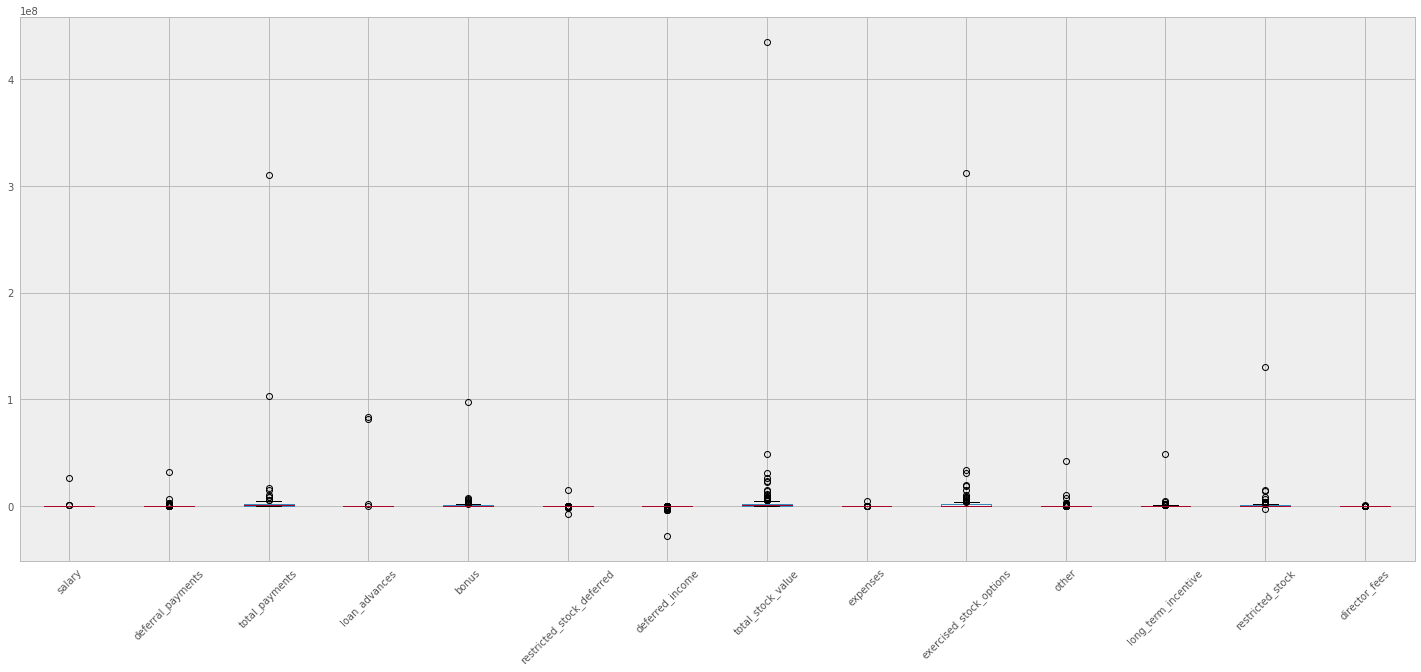

In [115]:
def plot_dataframe(dataframe):
    fig = plt.figure(figsize = (25,10))
    ax = fig.gca()
    pd.options.display.mpl_style = 'default'
    dataframe.boxplot(rot=45)
    
plot_dataframe(df[financial_features])


There are extreme outliers in the dataset which can be seen in total_stock_value, total_payments and excersized_stock_options. Let's see those outliers.


In [116]:
df[(df.total_stock_value > 4e8) | (df.total_payments > 3e8) | (df.exercised_stock_options > 3e8) ]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
TOTAL,26704229.0,1211.0,32083396.0,309886585.0,311764000.0,97343619.0,130322299.0,740.5,-7576788.0,434509511.0,...,83925000.0,41.0,42667589.0,8.0,False,1398517.0,-27992891.0,48521928.0,NaN,35.0


It is clearly seen that 'TOTAL' is an extreme outlier as expected since this is datapoint that shows the cumulative values in the dataset and does not represent a real user.

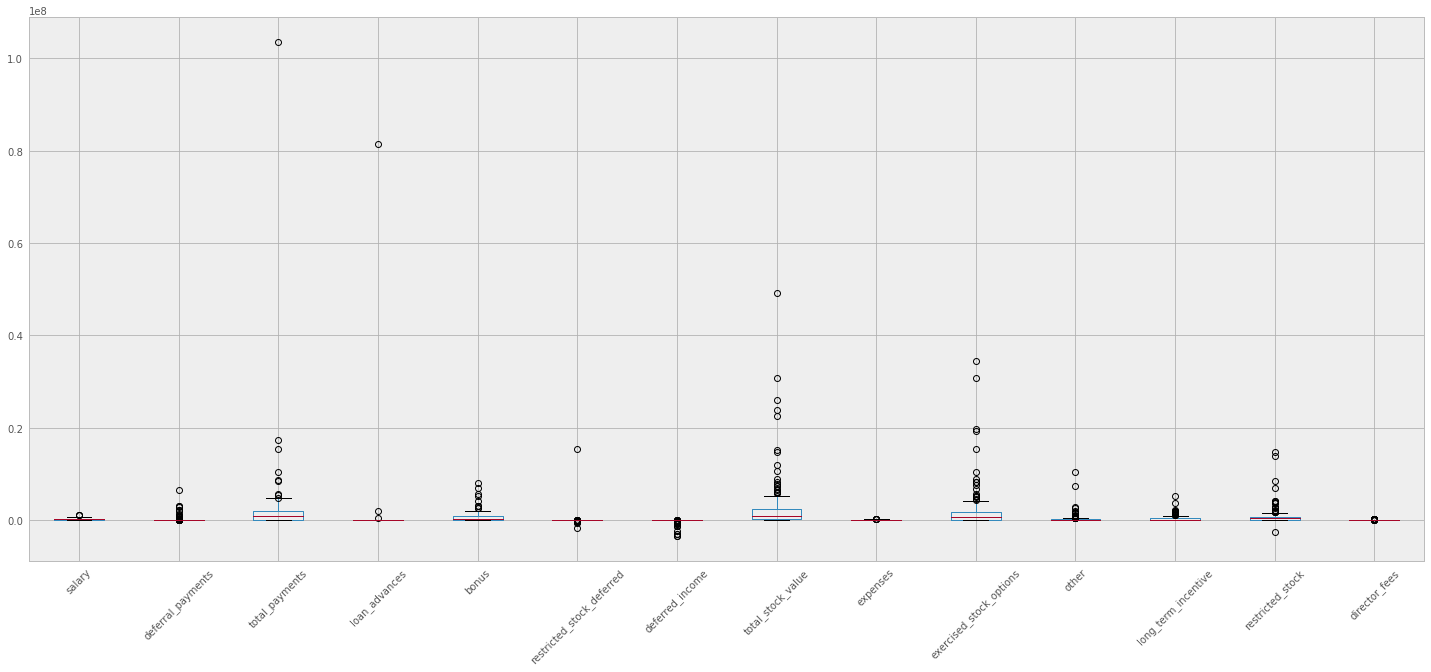

In [117]:
df = df.drop('TOTAL')
plot_dataframe(df[financial_features])

Now lets see mailing features whether if they contain any outliers.

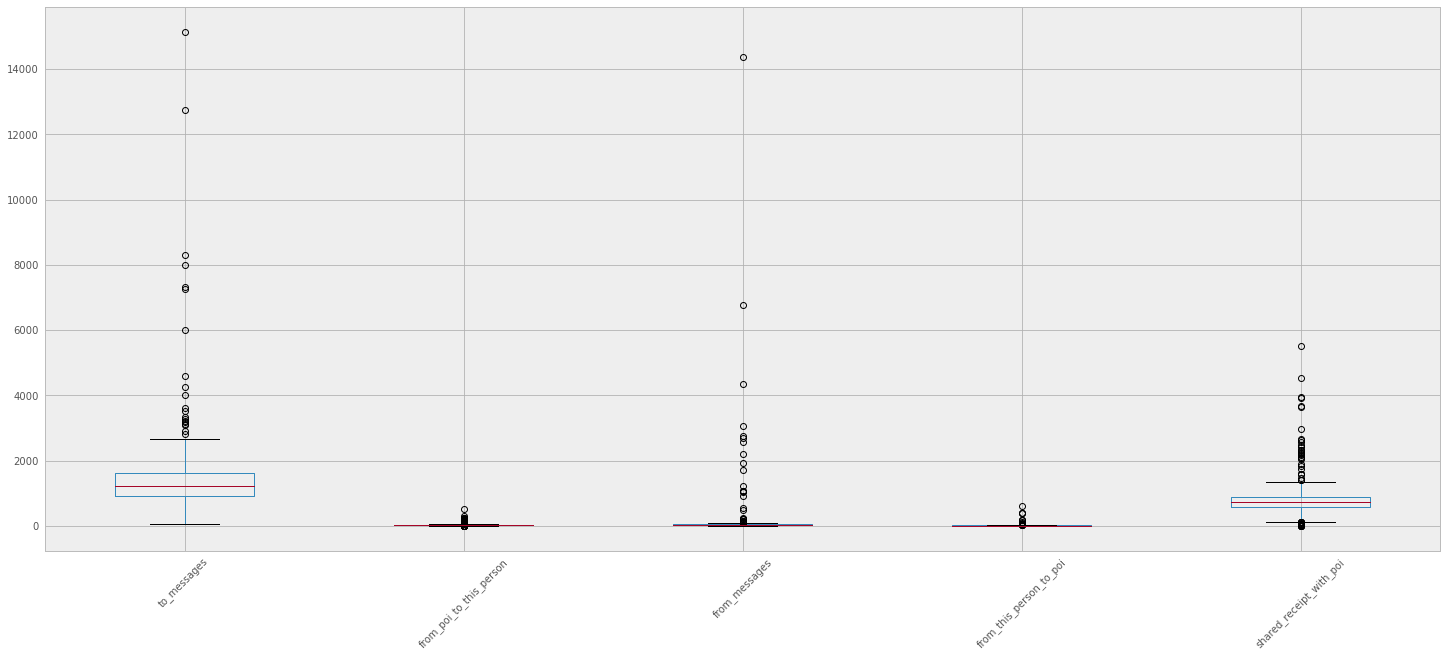

In [118]:
plot_dataframe(df[email_features])

In [119]:
df[(df.to_messages > 6000) | (df.from_messages > 1000) ]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,0.0,2195.0,152.0,65.0,False,0.0,-3081055.0,304805.0,phillip.allen@enron.com,47.0
BECK SALLY W,231330.0,7315.0,0.0,969068.0,0.0,700000.0,126027.0,2639.0,0.0,126027.0,...,0.0,4343.0,566.0,386.0,False,0.0,0.0,0.0,sally.beck@enron.com,144.0
BELDEN TIMOTHY N,213999.0,7991.0,2144013.0,5501630.0,953136.0,5249999.0,157569.0,5521.0,0.0,1110705.0,...,0.0,484.0,210698.0,108.0,True,0.0,-2334434.0,0.0,tim.belden@enron.com,228.0
BUY RICHARD B,330546.0,3523.0,649584.0,2355702.0,2542813.0,900000.0,901657.0,2333.0,0.0,3444470.0,...,0.0,1053.0,400572.0,71.0,False,0.0,-694862.0,769862.0,rick.buy@enron.com,156.0
DELAINEY DAVID W,365163.0,3093.0,0.0,4747979.0,2291113.0,3000000.0,1323148.0,2097.0,0.0,3614261.0,...,0.0,3069.0,1661.0,609.0,True,0.0,0.0,1294981.0,david.delainey@enron.com,66.0
HAEDICKE MARK E,374125.0,4009.0,2157527.0,3859065.0,608750.0,1150000.0,524169.0,1847.0,-329825.0,803094.0,...,0.0,1941.0,52382.0,61.0,False,0.0,-934484.0,983346.0,mark.haedicke@enron.com,180.0
HAYSLETT RODERICK J,0.0,2649.0,0.0,0.0,0.0,0.0,346663.0,571.0,0.0,346663.0,...,0.0,1061.0,0.0,38.0,False,0.0,0.0,0.0,rod.hayslett@enron.com,35.0
HORTON STANLEY C,0.0,2350.0,3131860.0,3131860.0,5210569.0,0.0,2046079.0,1074.0,0.0,7256648.0,...,0.0,1073.0,0.0,15.0,False,0.0,0.0,0.0,stanley.horton@enron.com,44.0
KAMINSKI WINCENTY J,275101.0,4607.0,0.0,1086821.0,850010.0,400000.0,126027.0,583.0,0.0,976037.0,...,0.0,14368.0,4669.0,171.0,False,0.0,0.0,323466.0,vince.kaminski@enron.com,41.0
KEAN STEVEN J,404338.0,12754.0,0.0,1747522.0,2022048.0,1000000.0,4131594.0,3639.0,0.0,6153642.0,...,0.0,6759.0,1231.0,387.0,False,0.0,0.0,300000.0,steven.kean@enron.com,140.0


There are outliers in mailing features, some people may have received or sent much more emails than the others. I do not think they are extreme outliers, however removing those datapoints will effect the distribution of the dataset postively.

In [120]:
df = df[df.to_messages < 6000]
df = df[df.from_messages < 1000]

### Feature Selection & Engineering

After wrangling phase, features that are more descriptive than the others will be selected in feature selection phase using scikit SelectKBest function. Since the aim is classification, f_classif method will be used to extract more descriptive features on the target feature.

REF: http://scikit-learn.org/stable/modules/feature_selection.html

In [121]:
from sklearn.feature_selection import SelectKBest, f_classif

filtered_features_df = df.drop(['poi', 'email_address'], axis=1)
target_feature = df.poi

feature_selector = SelectKBest(f_classif)
feature_selector.fit(filtered_features_df, target_feature)
# Get idxs of columns to keep
idxs_selected = feature_selector.get_support(indices=True)
features_dataframe_new = filtered_features_df[idxs_selected]
selected_features = list(features_dataframe_new)
print selected_features

['salary', 'to_messages', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'from_this_person_to_poi', 'deferred_income', 'long_term_incentive']


10 of 21 features were selected for classification methods based on SelectKBest function results.

After feature selection, those features will be engineered in order to improve the classification methods success.


In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score



def evaluate_classifier(clf, X, y):
    cv = StratifiedShuffleSplit(y, 100, random_state=42)
    print 'accuracy', cross_val_score(clf, X, y, cv=cv).mean()
    print 'precision', cross_val_score(clf, X, y, scoring=make_scorer(precision_score), cv=cv).mean()
    print 'recall', cross_val_score(clf, X, y, scoring=make_scorer(recall_score), cv=cv).mean()
    

def try_classifiers(X, y):
    print "GaussianNB Results"
    clf = GaussianNB()
    evaluate_classifier(clf, X, y)
    print
    
    print "DecisionTree Results"
    clf = DecisionTreeClassifier(random_state=42)
    evaluate_classifier(clf, X, y)
    print
    
    print "RandomForestClassifier Results"
    clf = RandomForestClassifier(random_state=42)
    evaluate_classifier(clf, X, y)
    print
    
    
    
X = df[selected_features]
y = df.poi
try_classifiers(X, y)

GaussianNB Results
accuracy 0.827692307692
precision 0.357333333333
recall 0.35

DecisionTree Results
accuracy 0.786153846154
precision 0.215
recall 0.24

RandomForestClassifier Results
accuracy 0.816923076923
precision 0.171666666667
recall 0.14



Selected features were ['salary', 'to_messages', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'from_this_person_to_poi', 'deferred_income', 'from_poi_to_this_person'].

I will engineer the mailing features as follows :

* to_message_poi_ratio = from_this_person_to_poi / to_messages
* from_message_poi_ratio = from_poi_to_this_person / from_messages
* message_in_out_ratio = from_messages / to_messages


In [130]:
df['to_message_poi_ratio'] = df['from_this_person_to_poi'] / df['to_messages']
df['from_message_poi_ratio'] = df['from_poi_to_this_person'] / df['from_messages']
df['message_in_out_ratio'] = df['from_messages'] / df['to_messages']


engineered_features = selected_features + ['from_message_poi_ratio', 'message_in_out_ratio', 'to_message_poi_ratio']
dropped_features = ['from_this_person_to_poi', 'to_messages']

def created_engineered_dataframe(engineered_f, dropped_f, data_frame):
    X_engineered = data_frame[engineered_features]
    X_engineered = X_engineered.drop(dropped_features, axis=1)
    return X_engineered

X = created_engineered_dataframe(engineered_features, dropped_features, df)
y = df.poi
try_classifiers(X, y)



GaussianNB Results
accuracy 0.839230769231
precision 0.3925
recall 0.365

DecisionTree Results
accuracy 0.803076923077
precision 0.300166666667
recall 0.305

RandomForestClassifier Results
accuracy 0.842307692308
precision 0.301666666667
recall 0.2



### Parameter Tuning

NaiveBayes results lower than Random Forest and AdaBoost models. Therefore, parameter tuninig is applied for Random Forest and Ada Boost models.

For random forest, criterion, min_samples_leaf, max_features and max_depth parameters were tried using grid search. Best results were seen in below parameter options: 

{'max_features': 2, 'min_samples_split': 4, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}


In [131]:
from sklearn.grid_search import GridSearchCV


grid = {
    'criterion':('gini', 'entropy'),
    'min_samples_split':[2,4],
    'min_samples_leaf':range(1, 50, 5),
    'max_features':range(1,10),
    'max_depth': range(1, 10)
}

search = GridSearchCV(RandomForestClassifier(random_state=42),
                      grid, make_scorer(f1_score), cv=StratifiedKFold(y), n_jobs=-1)
search.fit(X, y)

print search.best_score_
print search.best_params_

evaluate_classifier(search.best_estimator_, X, y)

0.35535868094
{'max_features': 2, 'min_samples_split': 4, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}
accuracy 0.85
precision 0.286666666667
recall 0.195


For Decision Tree, best estimator criterion, best results were seen in below parameter options: 

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}

In [127]:
grid = {
    'criterion': ('gini', 'entropy'),
    'min_samples_leaf':range(1, 50, 5),
    'max_depth': range(1, 10)
}

search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                      grid, make_scorer(f1_score), cv=StratifiedKFold(y), n_jobs=-1)
search.fit(X, y)
print search.best_score_
print search.best_params_

evaluate_classifier(search.best_estimator_, X, y)

0.340051679587
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}
accuracy 0.809230769231
precision 0.35669047619
recall 0.34


As a classification method, I choose Decision Tree with parameters {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1} since it gave the highest accuracy, (precision and recall > .3).


tester.py results are as below:

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=43, splitter='best')
            
            
       Accuracy: 0.77786       
       Precision: 0.31413     
       Recall: 0.46900 
       F1: 0.37625     
       F2: 0.42691
       Total predictions: 7000 
       True positives:  469    
       False positives: 1024   
       False negatives:  531   
       True negatives: 4976
        